# Iterative methods

## Linear Systems

To solve the linear system given $A\mathbf{x} = \mathbf{b}$,
we'll implement three iterative methods: Jacobi, Gauss-Seidel, and Successive Over Relaxation (SOR).

In [1]:
import numpy as np

A = np.array([[ 4, -1,  0], 
              [-1,  4, -1], 
              [ 0, -1,  4]])
b = np.array([ 2,  4, 10])
x0 = np.zeros(3)
eps = 10**-7

We will:

- Examine whether the sequence of vectors generated by each method's fixed point iteration function does converge to the analytic solution $\mathbf{x} = (1,2,3)^T$. 
- Take $\mathbf{x}_0 = (0,0,0)^T$ as our initial term and proceed until the $l_\infty$ norm of the difference between two successive approximations is less than $\varepsilon = 10^{-7}$.
- Time the convergence of each method with python's ``%%timeit`` magic function.

### Jacobi method 

This method simultaneously computes all entries in the output vector with matrix multiplication.

The function `jacobi` takes as input

- `A`, a 2-D square array
- `b` and `x0`, 1-D arrays

and outputs (the tuple)

- `x1`, a 1-D array that succeeds `x0` in approximating `b`
- `np.linalg.norm(x1 - x0, ord=np.inf)`, the $l_\infty$ norm of `x1-x0`

In [2]:
def jacobi(A,b,x0, *args):
    U = np.triu(A,1)
    D = np.diag(A)
    L = np.tril(A,-1)
    x1 = (1/D) * (b - np.matmul((L+U),x0))
    return x1, np.linalg.norm(x1 - x0, ord=np.inf)

We now iterate the state of `x_approx` by looping calls to the `jacobi` function while `interstep` is greater than $\varepsilon$.

In [3]:
U = np.triu(A,1)
D = np.diag(A)
L = np.tril(A,-1)
x1 = (1/D) * (b - np.matmul((L+U),x0))

In [4]:
x_approx = x0
interstep = eps+1 #must dominate eps to enter while loop
while interstep > eps:
    x_approx,interstep = jacobi(A,b,x_approx)
x_approx

array([0.99999997, 1.99999994, 2.99999997])

Lastly, we time the execution of the entire cell, and take the average of the 3 best results.

In [5]:
%%timeit
x_approx = x0
interstep = eps+1
while interstep > eps:
    x_approx,interstep = jacobi(A,b,x_approx)

1.14 ms ± 6.58 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Gauss-Seidel method

In contrast to the Jacobi method, the Gauss-Seidel method computes each entry `x1[i]` of the output vector in succession.

In [6]:
def gauss_seidel(A,b,x0, *args):
    n = len(x0)
    x1=np.zeros(n)
    for i in range(n):
        new = np.sum(A[i,:i] * x1[:i])
        old = np.sum(A[i,i+1:] * x0[i+1:])
        x1[i] = (1 / A[i,i]) * (b[i] - new - old)
    return x1, np.linalg.norm(x1 - x0, ord=np.inf)

We update `x_approx` in a similar a while loop.

In [7]:
x_approx = x0
interstep = eps+1
while interstep > eps:
    x_approx,interstep = gauss_seidel(A,b,x_approx)
x_approx

array([0.99999999, 1.99999999, 3.        ])

And we'll time it.

In [8]:
%%timeit
x_approx = x0
interstep = eps+1
while interstep > eps:
    x_approx,interstep = gauss_seidel(A,b,x_approx)

975 µs ± 82.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Successive over relaxation

Successive over relaxation generalizes the Gauss-Seidel method, and as such the `SOR` function requires an additional input `omega`. 

We choose the optimal parameter $\omega = 2/(1+\sqrt{7/8})$.

In [9]:
def SOR(A,b,x0,omega):
    n = len(x0)
    x1=np.zeros(n)
    for i in range(n):
        jaterm = (1-omega) * x0[i]
        gsnew = np.sum(A[i,:i] * x1[:i])
        gsold = np.sum(A[i,i+1:] * x0[i+1:])
        gsterm = (omega / A[i,i]) * (b[i] - gsnew - gsold)
        x1[i] = jaterm + gsterm
    return x1, np.linalg.norm(x1-x0, ord=np.inf)

In [10]:
omega = 2/(1+np.sqrt(7/8))
x_approx = x0
interstep = eps+1
while interstep > eps:
    x_approx,interstep = SOR(A,b,x_approx,omega)
x_approx

array([1., 2., 3.])

In [11]:
%%timeit
x_approx = x0
interstep = eps+1
while interstep > eps:
    x_approx,interstep = SOR(A,b,x_approx,omega)

777 µs ± 46.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Error analysis

The function `capture_error` logs the $l_\infty$ norm of the error as each `method` runs until the desired accuracy is achieved.

In [12]:
def capture_error(method,A,b,x_approx,omega,x_exact,eps):
    error = np.array([np.linalg.norm(x_approx - x_exact, ord=np.inf)])
    while error[-1] > eps:
        x_approx = method(A,b,x_approx,omega)[0]
        error = np.append(error,\
                np.linalg.norm(x_approx - x_exact, ord=np.inf))
    return error

We plot each method's error by iteration, and summarize.

In [13]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
ax = plt.figure().gca()

plt.title('Prob 1(b): $l_\infty$ norm of error by iteration')
x_exact = np.array([1,2,3])
for method in [jacobi,gauss_seidel,SOR]:
    ax.semilogy(capture_error(method,A,b,x0,omega,x_exact,eps),\
        label=method.__name__)
    
plt.legend()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

<Figure size 640x480 with 1 Axes>

To estimate the asymptotic error constant.

In [14]:
def est_asym_error(method,A,b,x0,omega,eps,k):
    interstep = np.array([eps+1])
    while interstep[-1] > eps:
        x1 = method(A,b,x0,omega)[0]
        interstep = np.append(interstep,\
                np.linalg.norm(x0 - x1, ord=np.inf))
        x0 = x1
    C = interstep[k+1]/interstep[k]
    return C

method | iterations | runtime | error const.
--- | --- | --- | ---
jacobi | 17 | ~1100 µs | 0.25
gauss_seidel | 10 | ~900 µs | 0.125
SOR | 7 | ~750 µs | 0.0489

## Nonlinear systems

Suppose we desire the points in the intersection of the circle $x^2 + y^2 = 4$ and the hyperbola $x^2 - y^2 = 1$.
In this case (and other cases where the polynomials in multiple variables are well behaved) the solutions are available in a closed form (that is, attainable from a finite number of arithmetic operations). 
For other cases, iterative methods allow us to work towards a solution with the first order Taylor expansion of the vector function $F:\mathbf{R}^n \to\mathbf{R}^n$.

### Newton's method

Here we demonstrate one iteration of Newton's method for the above system of non-linear equations (whose analytic solutions are the four points $\left\{(x,y) : x=1,y=\pm\sqrt{3}\right\}$), given the initial vector $(1, 1)^T$.

In [15]:
import sympy as sym

x,y = sym.symbols('x y')
F = sym.Matrix([x**2 + y**2 - 4, x**2 - y**2 - 1])
print("F    =", F)

J = F.jacobian(sym.Matrix([x,y]))
print("J    =", J)

init = [(x,1),(y,1)]
vec0 = sym.Matrix([coord[1] for coord in init])
print("vec0 =", vec0)

h = J.subs(init).LUsolve(-F.subs(init))
print("h    =", h)

vec1 = h + vec0
print("vec1 =", vec1)

F    = Matrix([[x**2 + y**2 - 4], [x**2 - y**2 - 1]])
J    = Matrix([[2*x, 2*y], [2*x, -2*y]])
vec0 = Matrix([[1], [1]])
h    = Matrix([[3/4], [1/4]])
vec1 = Matrix([[7/4], [5/4]])


# Interpolation

## Polynomial approximation

We'll write two series of functions to generate the interpolating polynomial as a vector in the space $\mathcal{P}_n$ of polynomials with degree at most $n$. The first will generate a basis of polynomials in the Lagrange form, the latter will do so in the Newton form. Both will then interpolate an arbitrary function $f \in C[a,b]$ at a finite number of points $x_i \in [a,b]$.

### Lagrange form

Consider $f \in C[a,b]$ (the set of continuous real-valued functions on the compact interval $[a,b]$), and let $x_0,\ldots,x_n$ be $n+1$ distinct points. Does there exist polynomial of least degree $p \in \mathbf{R}[x]$ which *interpolates* $f$ at the given points? such that $f(x_i) = p(x_i)$ for all $i \in \{0,1,\ldots,n\}$? Is it unique?

The fundamental theorem of algebra guarantees uniqueness (the difference between any two least degree interpolating polynomials is the zero polynomial), and the Lagrange form of the interpolating polynomial demonstrates existence.

Having $n+1$ distinct points $x_i$ specified, the $n+1$ Lagrange polynomials $\ell_k$ are written as the product $$\ell_k(x) = \prod_{i\neq k} \frac{x-x_i}{x_k-x_i} \text{ for all } k \in \{0,1,\ldots,n\}.$$

That is:

In [1]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
import math

def lagrange_basis(vecx):
    n = len(vecx)
    # choose n-1 of n entries
    hinges = [np.concatenate([vecx[:i], vecx[i+1:]]) for i in range(n)]
    # take product of n-1 terms, format into lambda functions
    polys = [lambda t, i=i: np.prod((t-hinges[i])/(vecx[i]-hinges[i]))\
            for i in range(n)]
    # returns a list of n functions, the Lagrange basis polynomials
    return polys

It can be shown that the set of $n+1$ Lagrange polynomials spans $\mathcal{P}_n$. We note the Lagrange polynomials form a basis for $\mathcal{P}_n$ since $\dim(\mathcal{P}_n) = n+1$.

For example:

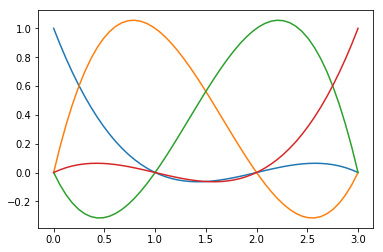

In [2]:
vecx = np.array([0,1,2,3])

def lagrange_basis_plot(vecx):
    polys = lagrange_basis(vecx)
    start, stop = np.min(vecx), np.max(vecx)
    stiple = np.linspace(start,stop)
    # returns a list of plots of the basis polynomials, overlaid
    return [plt.plot(stiple,[polys[i](t) for t in stiple])\
            for i in range(len(vecx))]

lagrange_basis_plot(vecx)
plt.show()

Now, to show the existence of an interpolating polynomial, we'll specify a linear combination of basis vectors $\{\ell_k : k=0,1,\ldots,n\}$.

Let $f \in C[a,b]$, and specify $n+1$ distinct points $x_i$. The interpolating polynomial in Lagrange form is $p_n \in \mathcal{P}_n$ where $$p_n(x) = \sum_{k=0}^n f(x_k) \ell_k(x).$$

We'll scale our basis polynomials:

In [3]:
def lagrange_coords(f,vecx):
    # returns the n coordinates of the interpolating polynomial
    # as a vector in $\mathcal{P}_n$ with the Lagrange basis
    return np.array([f(x) for x in vecx])

def interpol(coords,polys,t):
    # scales each vector by its coordinate
    scale = [lambda p, a=a: p * a for a in coords]
    # sums to form the desired linear combination
    # returns a (floating point) scalar
    return sum([scale[i](polys[i](t)) for i in range(len(polys))])

Since the degree of any linear combination of Lagrange polynomials (generated by $n+1$ distinct points) is $n$, and evaluated at any of the $n+1$ generating points $x_i$, the Lagrange $k$th polynomial is equal to the Kroenecker delta $$\delta_{ik} = \begin{cases} 1 &\text{ if } i=k\\ 0 &\text{ else,} \end{cases}$$ we have the least degree interpolating polynomial that we sought the existence of, $p_n$.

Consider the function $f(x) = e^x$, and the points $\{0,1,2,3\}$. 

We can compute:

In [4]:
import math

f = lambda x: math.exp(x)

# to specify the interpolating poly, p
polys = lagrange_basis(vecx)
coords = lagrange_coords(f,vecx)
p = lambda t: interpol(coords, polys, t)

# here's a couple evaluations
# notice interpolation has small relative error
print("exp(1.5) is approx  ", p(1.5)) 
print("exp(1.5) is exactly ", math.exp(1.5))

# while exterpolation may have great relative error
print("exp(4.0) is approx  ", p(4.0))
print("exp(4.0) is exactly ", math.exp(4.0))

exp(1.5) is approx   4.3675315264574746
exp(1.5) is exactly  4.4816890703380645
exp(4.0) is approx   45.88093841300295
exp(4.0) is exactly  54.598150033144236


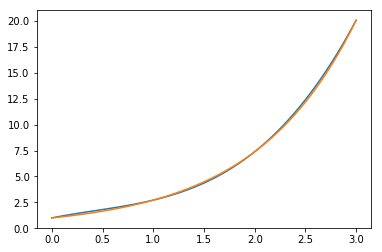

In [5]:
# we sample 50 points in the interval
start,stop = np.min(vecx),np.max(vecx)
stiple = np.linspace(start,stop)

# evaluate them to make a plot for p
fstiple = [interpol(coords, polys, t) for t in stiple]
plt.plot(stiple,fstiple)

# and overlay the exact plot f
plt.plot(stiple,np.array([f(t) for t in stiple]))
plt.show()

### Newton form

The Newton form allows us to compute $p_n$ from $p_{n-1}$ recursively. That is, we define $p_n$ with the same $n-1$ basis vectors and $n-1$ coordinates as $p_{n-1}$, but add a basis vector that's $0$ at all points $x_i$ where $i < n$.

Namely, $$p_n(x) = p_{n-1}(x)+a_n\prod_{i < n} (x-x_i)$$ with $$a_n = \left(f(x_n) - p_{n-1}(x_n)\right)\left(\prod_{i < n} (x_n-x_i)\right)^{-1}.$$

Here's a constructive definition, with accompanying plots for the same generating points $\{0,1,2,3\}$.

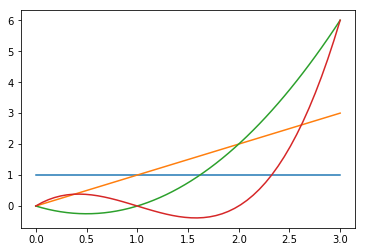

In [6]:
def newton_basis(vecx):
    n = len(vecx)
    # returns a list of n functions, the newton form basis polynomials
    return [lambda t, j=j: np.prod([t-vecx[i] for i in range(j)])\
            for j in range(n)]

def newton_basis_plot(vecx):
    polys = newton_basis(vecx)
    start, stop = np.min(vecx), np.max(vecx)
    stiple = np.linspace(start,stop)
    # returns a list of plots of the basis polynomials, overlaid
    return [plt.plot(stiple,[polys[i](t) for t in stiple])\
            for i in range(len(vecx))]

newton_basis_plot(vecx)
plt.show()

In practice we express the coordinate $a_n$ in recursive *divided differences*, i.e., $$a_n = f[x_0,\ldots,x_n] = \frac{f[x_1, \ldots, x_n] - f[x_0, \ldots, x_{n-1}]}{x_n-x_0}$$ where the identification $f[x] = f(x)$ for all $x$ is the base for recursion.

In [7]:
def dd(f, vecx):
    if len(vecx)>1:
    # recursive call, returns the coordinate of the nth newton poly
        return (dd(f,vecx[1:]) - dd(f,vecx[:-1]))/(vecx[-1]-vecx[0])
    # floor of recursion
    else:
        return f(vecx[0])

def newton_coords(f, vecx):
    # TODO: save the recursive divided difference calls in memory
    # so we don't have to iterate to load them into this array
    return np.array([dd(f,vecx[:i+1]) for i in range(len(vecx))])

When working with more than ~~a thousand~~ 30 generating points, we'd have to rewrite the above programs to cache intermediate recursive function calls. The most straight forward means to cache the divided differences is in a triangular matrix, writing an imperative program to append new diagonals for the calculation of the $n$th coefficient $a_n$.



The sentiment is also expressed in the setting of finite differences.

> An important advantage of finite-difference interpolation formulas...would seem to be the property...that enables a term to be added to them merely by adding one tabular point and computing an additional row of differences. ...This enables us to generate a sequence of interpolants each involving one more tabular point than the previous one. (1965 A. Ralston First Course Numerical Analysis iii. 57) 

(Aside: Python is not written to cache recursive calls, and as a rule taps out at 1000 levels deep. Pure functional, strictly typed languages like Haskell have compilers optimized to cache all recursions, and as well won't complain at any number of recursive calls.)

Anyways, the method does run smoothly for `len(vecx) < 25`:

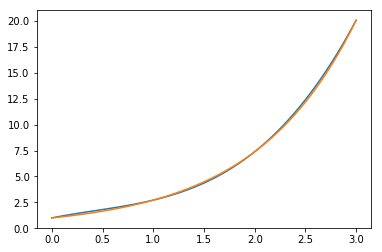

In [8]:
polys = newton_basis(vecx)
coords = newton_coords(f,vecx)
start,stop = np.min(vecx),np.max(vecx)
stiple = np.linspace(start,stop)
fstiple = [interpol(coords, polys, t) for t in stiple]
plt.plot(stiple,fstiple)
plt.plot(stiple,np.array([f(t) for t in stiple]))
plt.show()

We note the Newton form, 
$$p_n(x) = a_0 + a_1(x-x_0) + \cdots + a_n(x-x_0)\cdots(x-x_{n-1})$$
can be optimized also to be evaluated in  $O(n)$ operations, namely, $n$ multiplications and $n$ additions, by factoring 
$$p_n(x) =  a_0 + (x-x_0)\bigg(a_1 + (x-x_1)\Big(a_2+\cdots + a_n(x-x_{n-1})\cdots\Big)\bigg).$$

Our code presently *does not* redistribute parentheses to save computation, instead, it's written to compute each basis polynomial explicitly (in however many multiplications), scale them all, then sum. Such operations correspond closing with the matrix interpretation of the constraint $p_n = f$ at $n+1$ points $x_i$.

### Matrix interpretation

For $n+1$ generating points $(x_i,f(x_i))$, there is a unique interpolating polynomial $p_n$ of degree $n$.

But $p_n$ is just point in the vector space $\mathcal{P}_n$, so we should try to express the constraint that $p_n(x_i) = f(x_i)$ for all $i \in \{0,1,\ldots,n\}$ as $n+1$ linear equations to determine the coordinates of $p_n$. 

The constraint as a matrix equation (in any basis) is
$$A \begin{pmatrix}a_0\\ \vdots\\ a_n\end{pmatrix} = \begin{pmatrix}f(x_0)\\ \vdots\\ f(x_n)\end{pmatrix}.$$

We are required to choose a basis for $\mathcal{P}_n$, and we've thus far seen two:

- the Lagrange polynomials $\{\ell_0, \ell_1, \ldots, \ell_n\}$
- the basis of the Newton form $\{1, (x-x_0), \ldots, (x-x_n)\}$

For the Lagrange polynomial basis, we have simply $A = I$. In the Newton basis, $A$ is a lower triangular matrix. 

A third basis, the standard basis $\{1,x,x^2,\ldots, x^n\}$, yields a power series approximation to $f$, but corresponds to the highly ill-conditioned *Vandermode* matrix.

### Error analysis

Let $f \in C^{n+1}[a,b]$, the $x_i$ be $n+1$ distinct points in $[a,b]$, and suppose $p_n$ is a polynomial of degree at most $n$ that interpolates $f$ at the $x_i$. Given $x \in [a,b]$, there exists a point $\xi \in (a,b)$ such that $$f(x) = p_n(x) + \frac{f^{(n+1)}(\xi)}{(n+1)!}\prod_{\forall i}(x-x_i).$$

For example, interpolating $f = x \mapsto e^x$ on $[0,3]$ with the generating points $\{0,1,2,3\}$, the error is constrained:

In [9]:
import sympy as sym
z = sym.symbols('z')
prod = np.prod([z-i for i in range(4)])
max_prod = max([prod.subs(z,t) for t in sym.solve(sym.diff(prod,z), z)])
# take the worst xi possible, namely, xi=3
max_error = (math.exp(3)/24)*max_prod
max_error

0.470754771637211

## Determining the minimal degree

Here's a linear algebraic method to determine the degree of the minimal interpolating polynomial for a continuous function sampled at $n+1$ distinct points. It's equivalent to the computing the Newton form of the interpolating polynomial through divided differences, but emphasises that the constraints $p(x_i) = f(x_i)$ can be satisfied with a exactly one linear combination of vectors in the Newton form polynomial basis.

1. Write out the Newton form of the matrix $A$ in the constraint equation, $A \begin{pmatrix}a_0\\ \vdots\\ a_n\end{pmatrix} = \begin{pmatrix}f(x_0)\\ \vdots\\ f(x_n)\end{pmatrix}$.

$$A = \begin{pmatrix} 1 & & & 0\\
                       1 &(x_1 - x_0) & & \\
                       \vdots & \vdots & \ddots & \\
                       1 &(x_n - x_0) &\cdots &\prod_{i<n}(x_n - x_i)
       \end{pmatrix}$$
      
Elementwise, that's
$$(A_{ij}) = \left(\prod_{k=0}^{j-1} (x_i - x_k)\right).$$

2. Compute its inverse $A^{-1}$ (which exists as $\det A$ is the product of $A$'s nonzero diagonal entries).

3. Multiply $A^{-1} \begin{pmatrix}f(x_0)\\ \vdots\\ f(x_n)\end{pmatrix}$ to find $\vec{a} = 
\begin{pmatrix}a_0\\ \vdots\\ a_n\end{pmatrix}$. 

4. The degree of the interpolating polynomial is the index of the last nonzero element in $\vec{a}$.

As a basic example, consider the points $(0,1)$, $(1,1)$, and $(2,1)$; these are interpolated by the constant polynomial $p = 1$. Our method should corroborate this conclusion.

1. With the Newton form of the basis, the matrix $A$ is given 
$$A = \begin{pmatrix} 1 & 0 & 0\\ 1 & 1 & 0 \\ 1 & 2 & 2\end{pmatrix}.$$

2. The inverse exists and is given by
$$A^{-1}= \begin{pmatrix} 1 & 0 & 0 \\ -1 & 1 & 0\\ \frac12 & -1 & \frac12 \end{pmatrix}.$$

3. The coefficient vector $\vec{a}$ is thus
$$A^{-1} \begin{pmatrix}1 \\ 1 \\ 1\end{pmatrix} = \begin{pmatrix} 1\\0\\0\end{pmatrix}.$$

4. The degree of the interpolating polynomial is therefore $0$, as $a_0 = 1$ is the last non-zero entry in the coefficient vector. It follows that the interpolating polynomial has the (Newton) form $$p = \begin{pmatrix}1\\0\\0\end{pmatrix}\cdot\begin{pmatrix}x^0 \\x^1\\x^2\end{pmatrix} = 1\cdot x^0 + 0\cdot x^1 + 0 \cdot x^2.$$

Proceeding in the same fashion, we can find the degree of the minimal polynomial that interpolates the following $6$ points:

In [10]:
points = np.array([[-2, -1,  0,  1,  2,  3], [-5,  1,  1,  1,  7, 25]])

def nfA(vecx):
    n = len(vecx)
    a = lambda i,j : np.prod([vecx[i]-vecx[k] for k in range(j)])
    return np.array([[a(i,j) for j in range(n)] for i in range(n)])

nfA(points[0])

array([[  1.,   0.,   0.,   0.,   0.,   0.],
       [  1.,   1.,   0.,   0.,   0.,   0.],
       [  1.,   2.,   2.,   0.,   0.,   0.],
       [  1.,   3.,   6.,   6.,   0.,   0.],
       [  1.,   4.,  12.,  24.,  24.,   0.],
       [  1.,   5.,  20.,  60., 120., 120.]])

In [11]:
# this function equivalent to computing divided differences
np.linalg.solve(nfA(points[0]),points[1])

array([-5.,  6., -3.,  1.,  0.,  0.])

We see the last nonzero entry in the coefficient vector has index $3$, and therefore the minimal interpolating polynomial has degree $3$.

## Summing a set of Lagrange polynomials

Suppose we have $n+1$ distinct points $x_i \in \mathbf{R}$. Let the $n+1$ Lagrange polynomials be given by $\ell_k$ for $k \in \{0,1,\ldots,n\}$. Write $p_n = \sum_{k=0}^n 1\cdot\ell_k$, which interpolates the constant polynomial $f = 1$. For all real $x$ the error $\left\lvert f(x) - p_n(x)\right\rvert$ is bounded by 
$$\max_{\xi\in S}\left\lvert\frac{f^{(n+1)}(x)}{(n+1)!}\prod_{\forall i} (\xi - x_i)\right\rvert  = 0$$
as all derivatives of the constant function $f$ are identically zero. We conclude that $\sum{k=0}^n \ell_k \equiv 1\in \mathcal{P}_n$.

## Optimal choice of sample points

We plot two polynomials $w_n(x) = \prod_{\forall i} (x-x_i)$ generated by a set of $n+1$ points $x_i$, the first generated by linearly spaced points, the second generated by Chebyshev points.

We'll exploit the identity
$$\frac{\pi}{n+1}\left(\frac12 + i\right) = \frac{\pi}{2} + \frac{\pi}{2}\cdot\frac{n}{n+1}\left(-1 + \frac{2i}{n}\right)$$
to express the roots of the $n$th Chebyshev polynomial as an vectorized transformation of the linearly spaced array `vecx`.

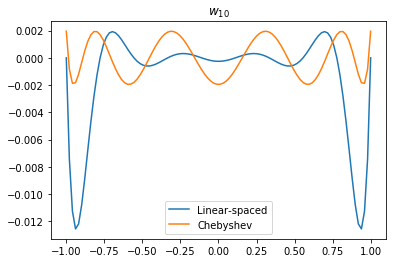

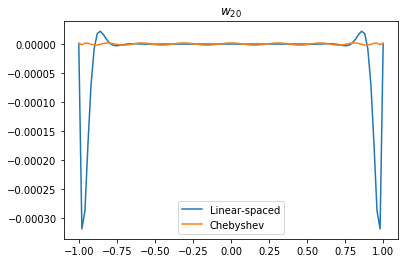

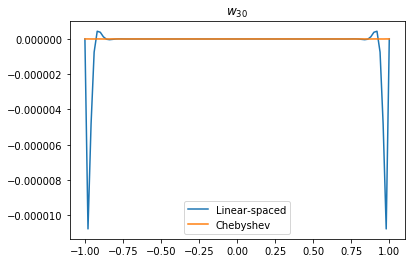

In [12]:
def w(vecx, x): 
    return np.product(vecx - x)

def chebyshev_transform(vecx):
    n = len(vecx) - 1
    return -1*np.cos(vecx*(np.pi/2)*n/(n+1) + np.pi/2)

def w_plot(vecx):
    stiple = np.linspace(-1,1,100)
    w_values = np.array([w(vecx, i) for i in stiple])
    return plt.plot(stiple,w_values)

def w_contrast(vecx):
    return w_plot(vecx), w_plot(chebyshev_transform(vecx))

for i in [10,20,30]:
    w_contrast(np.linspace(-1,1,i))
    plt.title('$w_{%d}$' % i)
    plt.legend(('Linear-spaced','Chebyshev'))
    plt.show()

Notice the $l_\infty$ norm of the Chebyshev $w_n$ is bounded by $2^{1-n}$.

### Comparison: Chebyshev and linearly spaced points

Here we interpolate two functions (the absolute value function and its first derivative) with the polynomial $p_n$ (for $n = 8, 16, 32$) generated by $n+1$ linearly spaced and chebyshev points on the interval $[-1,1]$, respectively.

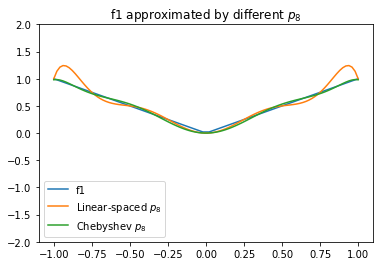

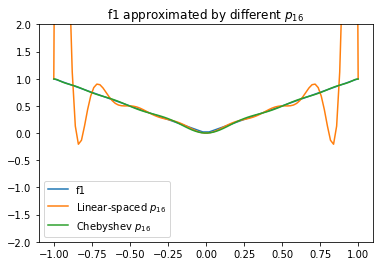

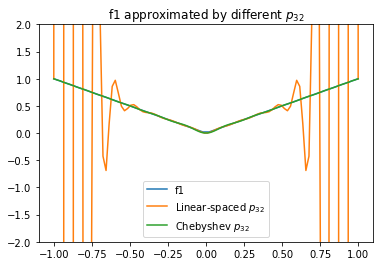

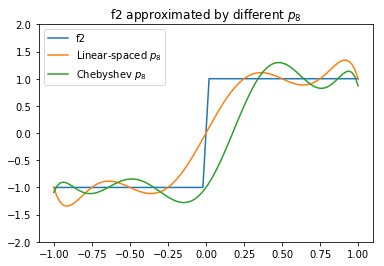

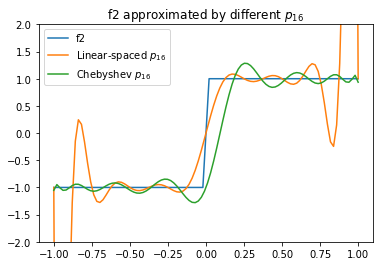

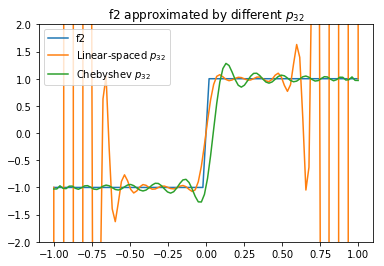

In [13]:
def f1(x): 
    return abs(x)

def f2(x): 
    return -1 if x<0 else 1 if x>0 else 0

def ptuples(f, vecx):
    polys = lagrange_basis(vecx)
    coords = lagrange_coords(f, vecx)
    stiple = np.linspace(-1,1,100)
    interstiple = np.array([interpol(coords,polys,t) for t in stiple])
    return np.vstack([stiple,interstiple])

for f in [f1,f2]:
    for n in [8, 16, 32]:
        linear = np.linspace(-1,1,n+1)
        chebyshev = chebyshev_transform(linear)
        p_linear = ptuples(f, linear)
        p_chebyshev = ptuples(f, chebyshev)
        plt.plot(np.linspace(-1,1),[f(t) for t in np.linspace(-1,1)])
        plt.plot(p_linear[0],p_linear[1])
        plt.plot(p_chebyshev[0],p_chebyshev[1])
        plt.ylim(-2,2)
        plt.title(f.__name__ + ' approximated by different $p_{%d}$' % n)
        plt.legend((f.__name__,'Linear-spaced $p_{%d}$' % n,'Chebyshev $p_{%d}$' % n))
        plt.show()

Each method for choosing sample points naturally corresponds with a power series representation of the function to be interpolated. 

That is, there's a bijection between the sequence of functions $c_n:\mathbf{N} \to \mathbf{R}^n$ (used to choose sample points $\{x_i : i = 0,1,\ldots, n\}$) and the partial sums of the power-series $\sum_{k=0}^{n}a_k \prod_{i< k}(x-x_i)$ with the coefficients $a_n$ generated by divided differences. Call this power-series $p_\infty$.

Looking at the above plots, and applying a bit of mind's eye real-analytic intuition, I suggest.

- When $p_n$ is generated by Chebyshev points

  - $p_\infty(x) = f_1(x)$ for all $x$ in $[-1,1]$
  - $p_\infty(x) = f_2(x)$ for all $x$ in $[-1,1]\setminus \{0\}$
  
- When $p_n$ is generated by linearly spaced points

  - $p_\infty(x) = f_1(x)$ at countably many sample points, else nowhere.
  - $p_\infty(x) = f_2(x)$ at countably many sample points, else nowhere.

In other words, Chebyshev sample points seem to produce sequences of polynomials that converge uniformly to the function they interpolate (provided that function is continuous), whereas linearly spaced sample points (at least on compact sets $[a,b]$ where $\lvert b-a \rvert > 1$) produce sequences of polynomials that don't even converge pointwise to their interpolating functions.

### Hermite interpolation

Hermite interpolation can be setup in an analogous fashion to (plain) interpolation: we just obtain $2n+2$ equations from $n+1$ function and $n+1$ derivative evaluations at the sample points. 

Here's the Lagrange form implementation:

In [14]:
def hermite_basis(vecx):
    lp = lagrange_basis(vecx)
    # appealing to sympy for differentiation
    # TODO implement numerically
    dp = [sym.diff(l(sym.Symbol('x'))) for l in lp]
    hf = [lambda t, i=i:\
            (1-2*dp[i].subs(x,vecx[i])*(t-vecx[i]))*lp[i](t)**2\
            for i in range(len(vecx))]
    hh = [lambda t, i=i:\
            (t-vecx[i])*(lp[i](t))**2\
            for i in range(len(vecx))]
    return [hf,hh]

def lagherm_coords(f,vecx):
    vecf = [f(vecx[i]) for i in range(len(vecx))]
    df = lambda t: f(sym.Symbol('x')).diff(x).subs(x,t)
    vecdf = [df(vecx[i]) for i in range(len(vecx))]
    return [np.array(vecf), np.array(vecdf)]

# TODO rewrite hermite_basis & lagherm_coords to
# avoid flattening their outputs
flatten = lambda l: [item for sublist in l for item in sublist]

def lagherm_interpol(lagherm_coords, hermite_basis, t):
    coords = flatten(lagherm_coords)
    polys = flatten(hermite_basis)
    scale = [lambda p, a=a: p * a for a in coords]
    return sum([scale[i](polys[i](t)) for i in range(len(polys))])

Consider the specific case $f(x) = x \ln x$, with sample points $(x_0, x_1)  = (1, 3)$.

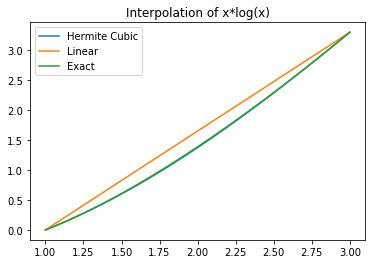

In [15]:
x = sym.Symbol('x')
f = lambda x: x*sym.log(x)
vecx = np.array([1,3])

def prob8plots():
    # we define the osculatory cubic polynomial
    coordinates = lagherm_coords(f,vecx)
    basis = hermite_basis(vecx)
    H = lambda t: lagherm_interpol(coordinates, basis, t)

    # and generate stiples for plotting
    stiple = np.linspace(1,3)
    Hstiple = [H(t) for t in stiple]
    plt.plot(stiple,Hstiple)

    # for comparison, here's the linear interpolant
    m = (f(3) - f(1))/2
    line = lambda x: m*(x-1) + f(1)
    lstiple = line(stiple)
    plt.plot(stiple,lstiple)

    # and the exact graph
    fstiple = [f(t) for t in stiple]
    plt.plot(stiple,fstiple)
    plt.title('Interpolation of '+str(f(sym.Symbol('x'))))
    plt.legend(('Hermite Cubic','Linear', 'Exact'))
    plt.show()

prob8plots()

The approximation is so close, we don't get a chance to build any intuition around how stiff a cubic polynomial really is---stiff. We'll interpolate two other analytic functions on $[1,3]$ to demonstrate this effect. Notably $f(x) = \tan(x/2)$ is singular about $pi$, so the osculatory polynomial will really have to *strech* to match $f'(3)$.

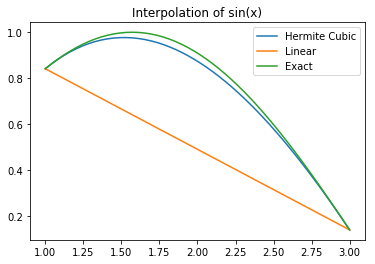

In [16]:
f = lambda x: sym.sin(x)
prob8plots()

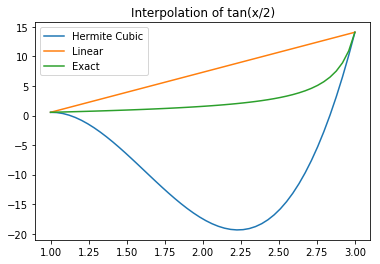

In [17]:
f = lambda x: sym.tan(x/2)
prob8plots()

Returning to $f(x) = x \ln x$, as desired, we compare the exact value, the Hermite interpolant, and the linear interpolant at $x =1.5$.

In [18]:
f = lambda x: x*sym.log(x)
# reset mutated Hermite poly back to xlnx
# TODO get these assignments out of the global namespace
basis = hermite_basis(vecx)
coordinates = lagherm_coords(f,vecx)
H = lambda t: lagherm_interpol(coordinates, basis, t)
m = (f(3) - f(1))/2
line = lambda x: m*(x-1) + f(1)

print(f(1.5).evalf())
print(H(1.5).evalf())
print(line(1.5).evalf())

0.608197662162247
0.599479608250541
0.823959216501082


Now we'll compute the error bound.

In [19]:
def hermite_error_bound(f, vecx):
    w = lambda x: np.prod([(x-i)**2 for i in vecx])
    # extreme values of cts diff'ble func on compact set
    extrema = sym.solve(sym.diff(w(sym.Symbol('x')),x),x)
    worst_wiggle = max([abs(w(x)) for x in extrema])
    jerk = sym.diff(f(sym.Symbol('x')),x,2*len(vecx))
    # assume $f^{(2n+n)}$ is monotone and find extrema at endpoints
    worst_jerk = max([jerk.subs(x,i) for i in vecx])
    return (abs(worst_jerk)*worst_wiggle)/sym.factorial(2*len(vecx))

hermite_error_bound(f, vecx).evalf()

0.0833333333333333

To verify, consider the function given by distance at $x$ between $f$ and its Hermite interpolant. To find its extrema, we'll solve $(f - H)'(x) =0$.

In [20]:
# we define the desired fixed point iterator
err = f(sym.Symbol('x')) - H(sym.Symbol('x'))
g = lambda t: t - (sym.diff(err,x)/sym.diff(err,x,2)).subs(x,t)

# recall a fixed point iterating algorithm
def fixedpt(g, x0, eps, Nmax):
    i=0; seq = [x0]
    x1 = g(x0).evalf()
    while abs(x1 - x0) >= eps * abs(x1) and i < Nmax:
        x0 = x1
        x1 = g(x1).evalf()
        i += 1
        seq = seq + [x1]
    return seq

# and search for roots with parameters
eps = 10**(-8); Nmax = 10

# I start at 1.1, 2.0, and 2.9, just guessing the cubic polynomial is
# crossing the function 3 times...

[fixedpt(g, x0, eps, Nmax)[-1] for x0 in [1.1,2,2.9]]

[0.999999999999996, 1.91984231854365, 3.00000000000000]

Good, the endpoints should be minima for the absolute error (the polynomial *was* constructed to match the function at $1$ and $3$). A continuous function on a compact set has alternating extrema, so we should have maximal absolute error around `1.92`. That error is:

In [21]:
err.subs(x, 1.92).evalf()

0.0131939381401981

Consider the same analysis performed on $x \mapsto \sin(x)$ or $x \mapsto \tan(x/2)$

In [22]:
f = lambda x: x*sym.sin(x)
coordinates = lagherm_coords(f,vecx)
H = lambda t: lagherm_interpol(coordinates, basis, t)
print('bound: ' + str(hermite_error_bound(f, vecx).evalf()))

err = f(sym.Symbol('x')) - H(sym.Symbol('x'))
g = lambda t: t - (sym.diff(err,x)/sym.diff(err,x,2)).subs(x,t)
c = fixedpt(g, 2, eps, Nmax)[-1]
print('worst: ' + str(err.subs(x,c).evalf()))

bound: 0.182638750440891
worst: 0.134275292380452


In [23]:
f = lambda x: x*sym.tan(x/2)
coordinates = lagherm_coords(f,vecx)
H = lambda t: lagherm_interpol(coordinates, basis, t)
err = f(sym.Symbol('x')) - H(sym.Symbol('x'))
g = lambda t: t - (sym.diff(err,x)/sym.diff(err,x,2)).subs(x,t)

print('bound: ' + str(hermite_error_bound(f, vecx).evalf()))

bound: 110401.830454949


In [24]:
# Since the error changes dramatically when interpolating tangent, finding the
# extrema of the error function is a bit trickier.
regimes = np.empty((0,3), float)
for x0 in np.linspace(1,3,21):
    c = fixedpt(g, x0, eps, Nmax)[-1]
    fc = err.subs(x,c).evalf()
    regimes = np.vstack([regimes,\
              np.array([x0, c, fc]).astype(float)])

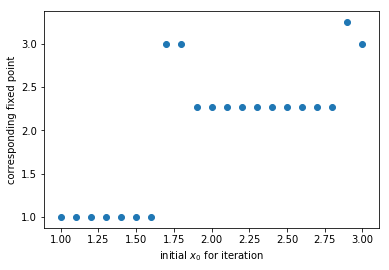

In [25]:
plt.scatter(regimes[0:, 0], regimes[0:, 1])
plt.xlabel('initial $x_0$ for iteration')
plt.ylabel('corresponding fixed point')
plt.show()

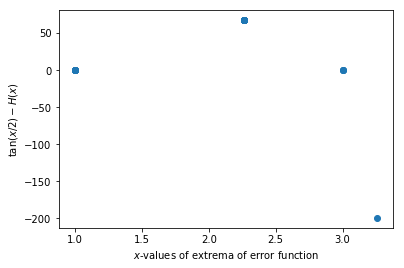

In [26]:
plt.scatter(regimes[0:, 1], regimes[0:, 2])
plt.xlabel('$x$-values of extrema of error function')
plt.ylabel(r'$\tan(x/2) - H(x)$')
plt.show()

Which is all to say that $\tan(x/2) - H(x)$ on $[1,3]$ is at max $67.3952$, clearly bounded by $110401.8305$. 

## Mixed initial conditions

We find the polynomial $p$ of least degree (i.e., $\deg p \leq 4$) satisfying

\begin{align*}
p(1) &= -1\\
p(2) &= 1\\
p'(1) &= 2\\
p'(2) &= -2\\
p''(1) &=0\\
\end{align*}

With Newton's divided difference table, we compute the coeffecients $-1,2,0,0,-4$, and write 
$p(x) = -1 + 2(x-1) + 4(x-1)^3(x-2)$. Verifying,

In [32]:
p = lambda x: -1 + 2*(x-1) - 4*(x-1)**3 *(x-2)
dp = lambda t: sym.diff(p(sym.Symbol('x')),x).subs(x,t)
d2p = lambda t: sym.diff(p(sym.Symbol('x')),x,2).subs(x,t)

p(1),p(2),dp(1),dp(2),d2p(1)

(-1, 1, 2, -2, 0)